In [ ]:
!pip install open3d
!pip install git+https://github.com/giacaglia/pytube.git --upgrade
!git clone https://github.com/mkocabas/VIBE
!pip install yacs
!pip install smplx
!pip install trimesh
!pip install pyrender
!pip install filterpy
!pip install chumpy
!pip install smplpytorch
!pip install git+https://github.com/mkocabas/yolov3-pytorch.git
!pip install git+https://github.com/pytorch/vision.git

!pip install git+https://github.com/mkocabas/multi-person-tracker.git

!pip install git+https://github.com/gulvarol/smplpytorch.git

!pip install chumpy
!pip install smplpytorch
!pip install aspose-3d

%cd VIBE
!mkdir -p data
!cd data
!gdown "https://drive.google.com/uc?id=1untXhYOLQtpNEy4GTY_0fL_H-k6cTf_r"
!unzip vibe_data.zip

In [ ]:
%cd VIBE

/content/VIBE


In [ ]:
!pwd

/content


In [ ]:
import os
import cv2
import imageio
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
import numpy as np
import time
import open3d as o3d
import torch.backends.cudnn as cudnn
import torch
from smplx import SMPL
from smplpytorch.pytorch.smpl_layer import SMPL_Layer
from torch.utils.data import DataLoader
from multi_person_tracker import MPT
from lib.models.vibe import VIBE_Demo
from lib.utils.renderer import Renderer
from lib.dataset.inference import Inference
from lib.utils.smooth_pose import smooth_pose
from lib.data_utils.kp_utils import convert_kps
from lib.utils.pose_tracker import run_posetracker
from smplx import SMPL
from smplpytorch.pytorch.smpl_layer import SMPL_Layer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from lib.utils.demo_utils import (
    download_youtube_clip,
    smplify_runner,
    convert_crop_coords_to_orig_img,
    convert_crop_cam_to_orig_img,
    prepare_rendering_results,
    video_to_images,
    images_to_video,
    download_ckpt,
)

In [ ]:
def depth2orthomesh(depth, x_step=1, y_step=1, scale=[1.0, 1.0, 1.0], minus_depth=True):
    vertices = []
    faces = []
    if len(depth.shape) != 2:
        return None
    h, w = depth.shape
    vertex_id = 0
    added_table = {}
    for y in range(0, h, y_step):
        for x in range(0, w, x_step):
            added_table[(y, x)] = -1
    max_connect_z_diff = 99999.9
    # TODO
    # pixel-wise loop in pure python is toooooooo slow
    for y in range(0, h, y_step):
        for x in range(0, w, x_step):
            d = depth[y, x]
            if d <= 0.000001:
                continue
            if minus_depth:
                d = -d

            vertices.append([x * scale[0], y * scale[1], d * scale[2]])

            added_table[(y, x)] = vertex_id

            current_index = vertex_id
            upper_left_index = added_table[((y - y_step), (x - x_step))]
            upper_index = added_table[((y - y_step), x)]
            left_index = added_table[(y, (x - x_step))]

            upper_left_diff = np.abs(depth[y - y_step, x - x_step] - d)
            upper_diff = np.abs(depth[y - y_step, x] - d)
            left_diff = np.abs(depth[y, x - x_step] - d)

            if upper_left_index > 0 and upper_index > 0\
               and upper_left_diff < max_connect_z_diff\
               and upper_diff < max_connect_z_diff:
                faces.append([upper_left_index, current_index, upper_index])

            if upper_left_index > 0 and left_index > 0\
                and upper_left_diff < max_connect_z_diff\
                    and left_diff < max_connect_z_diff:
                faces.append([upper_left_index, left_index, current_index])

            vertex_id += 1
    return vertices, faces

In [ ]:
path='/content/'

img = cv2.imread('/content/Test_Image/salto.png',0)#Figure_1.png  car11.png frame1.png scene.png
img=cv2.resize(img, (128,128), interpolation = cv2.INTER_AREA)

model = cv2.dnn.readNet(path+'model-small.onnx')
if (model.empty()):
    print("Could not load the neural net! - Check path")
model.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
model.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
imgHeight, imgWidth= img.shape

In [ ]:
start = time.time()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Create Blob from Input Image
# MiDaS v2.1 Large ( Scale : 1 / 255, Size : 384 x 384, Mean Subtraction : ( 123.675, 116.28, 103.53 ), Channels Order : RGB )
#blob = cv2.dnn.blobFromImage(img, 1/255., (384,384), (123.675, 116.28, 103.53), True, False)

# MiDaS v2.1 Small ( Scale : 1 / 255, Size : 256 x 256, Mean Subtraction : ( 123.675, 116.28, 103.53 ), Channels Order : RGB )
blob = cv2.dnn.blobFromImage(img, 1/255., (256,256), (123.675, 116.28, 103.53), True, False)

# Set input to the model
model.setInput(blob)

# Make forward pass in model
depth = model.forward()

depth = depth[0,:,:]

depth = cv2.resize(depth, (imgWidth, imgHeight))

# Normalize the output
depth = cv2.normalize(depth, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# End time
end = time.time()
time_pro=end-start
print(str(float("{:.2f}".format(time_pro*1000)))+' ms')


218.43 ms


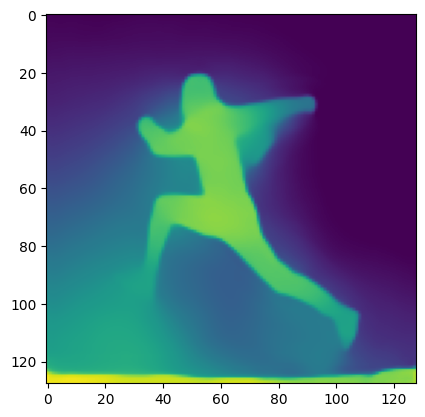

In [ ]:
depth=output
plt.imshow(output)

**Pre-Training**

In [ ]:
def display_model(model_info, model_faces=None, with_joints=False, kintree_table=None,
                  ax=None, batch_idx=0, show=True, savepath=None):
    """
    Displays the mesh batch_idx in the batch of model_info, model_info as returned by generate_random_model.
    """
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    device = model_info['verts'].device
    verts = model_info['verts'][batch_idx].cpu().detach().numpy()
    joints = model_info['joints'][batch_idx].cpu().detach().numpy()

    if model_faces is None:
        ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], alpha=0.2)
    else:
        mesh = Poly3DCollection(verts[model_faces.cpu().detach().numpy()], alpha=0.2)
        face_color = (141 / 255, 184 / 255, 226 / 255)
        edge_color = (50 / 255, 50 / 255, 50 / 255)
        mesh.set_edgecolor(edge_color)
        mesh.set_facecolor(face_color)
        ax.add_collection3d(mesh)

    if with_joints:
        draw_skeleton(joints, kintree_table=kintree_table, ax=ax)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim(-0.7, 0.7)
    ax.set_ylim(-0.7, 0.7)
    ax.set_zlim(-0.7, 0.7)
    ax.view_init(azim=-90, elev=270)
    ax.axis("off")
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    if savepath:
        print('Saving figure at {}.'.format(savepath))
        plt.savefig(savepath, bbox_inches='tight', pad_inches=0)

    if show:
        plt.show()

    return ax

def draw_skeleton(joints3D, kintree_table, ax=None, with_numbers=True):
    if ax is None:
        fig = plt.figure(frameon=False)
        ax = fig.add_subplot(111, projection='3d')
    else:
        ax = ax

    colors = []
    left_right_mid = ['r', 'g', 'b']
    kintree_colors = [2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 0, 1, 0, 1, 0, 1]
    for c in kintree_colors:
        colors += left_right_mid[c]
    # For each 24 joint
    for i in range(1, kintree_table.shape[1]):
        j1 = kintree_table[0][i]
        j2 = kintree_table[1][i]
        ax.plot([joints3D[j1, 0], joints3D[j2, 0]],
                [joints3D[j1, 1], joints3D[j2, 1]],
                [joints3D[j1, 2], joints3D[j2, 2]],
                color=colors[i], linestyle='-', linewidth=2, marker='o', markersize=5)
        if with_numbers:
            ax.text(joints3D[j2, 0], joints3D[j2, 1], joints3D[j2, 2], j2)
    return ax


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
smpl_layer = SMPL_Layer(
        center_idx=0,
        gender='male',
        model_root='/content/SMPLX_Model/Model')

model = VIBE_Demo(
        seqlen=16,
        n_layers=2,
        hidden_size=1024,
        add_linear=True,
        use_residual=True,
    ).to(device)

pretrained_file = download_ckpt(use_3dpw=False)
ckpt = torch.load(pretrained_file)
print(f'Performance of pretrained model on 3DPW: {ckpt["performance"]}')
ckpt = ckpt['gen_state_dict']

model.load_state_dict(ckpt, strict=False)
model.eval()
print(f'Loaded pretrained weights from \"{pretrained_file}\"')

mot = MPT(
            device=device,
            batch_size=12,
            display=False,
            detector_type='yolo',
            output_format='dict',
            yolo_img_size=416,
        )

**SMPL-X**

In [ ]:
#Step 1
tracking_results = mot('/content/Test_Image')
ID=list(tracking_results.keys())[0]

bboxes = joints2d = None
bbox_scale=1.1

bboxes = tracking_results[ID]['bbox']
frames = tracking_results[ID]['frames']

Running Multi-Person-Tracker


100%|██████████| 1/1 [00:00<00:00, 17.46it/s]

Finished. Detection + Tracking FPS 15.67


Saving figure at image.png.


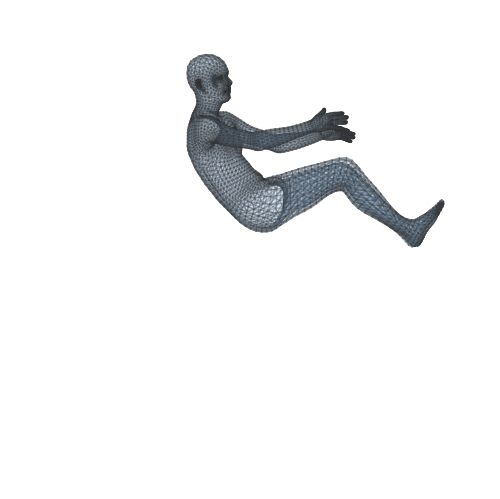

<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

In [ ]:
dataset = Inference(
            image_folder='/content/Test_Image',
            frames=frames,
            bboxes=bboxes,
            joints2d=joints2d,
            scale=bbox_scale,
        )

bboxes = dataset.bboxes
frames = dataset.frames
has_keypoints = True if joints2d is not None else False

dataloader = DataLoader(dataset, batch_size=450, num_workers=16)

with torch.no_grad():

            pred_cam, pred_verts, pred_pose, pred_betas, pred_joints3d, smpl_joints2d, norm_joints2d = [], [], [], [], [], [], []

            for batch in dataloader:
                if has_keypoints:
                    batch, nj2d = batch
                    norm_joints2d.append(nj2d.numpy().reshape(-1, 21, 3))

                batch = batch.unsqueeze(0)
                batch = batch.to(device)

                batch_size, seqlen = batch.shape[:2]
                output = model(batch)[-1]


pred_pose=output['theta'][:,:,3:75].reshape(batch_size * seqlen, -1)
pred_betas=output['theta'][:, :,75:].reshape(batch_size * seqlen, -1)

pred_cam=output['theta'][:, :, :3].reshape(batch_size * seqlen, -1)
pred_verts=output['verts'].reshape(batch_size * seqlen, -1, 3)
pred_joints3d=output['kp_3d'].reshape(batch_size * seqlen, -1, 3)
smpl_joints2d=output['kp_2d'].reshape(batch_size * seqlen, -1, 2)


#pose_params = pred_pose.cuda()
#shape_params = pred_betas.cuda()
smpl_layer.cuda()

#verts, Jtr = smpl_layer(pose_params, th_betas=shape_params)

display_model(
        {'verts': pred_verts,
         'joints': pred_joints3d},
        model_faces=smpl_layer.th_faces,
        with_joints=False,
        kintree_table=smpl_layer.kintree_table,
        savepath='image.png',
        show=True)

In [ ]:
pred_cam = pred_cam.cpu().numpy()
pred_verts = pred_verts.cpu().numpy()
pred_pose = pred_pose.cpu().numpy()
pred_betas = pred_betas.cpu().numpy()
pred_joints3d = pred_joints3d.cpu().numpy()
smpl_joints2d = smpl_joints2d.cpu().numpy()

In [ ]:
vertices=pred_verts.cpu().numpy()
faces=smpl_layer.th_faces.cpu().numpy()

In [ ]:
faces.shape

(13776, 3)

**Convert FBX**

In [ ]:
import trimesh
import aspose.threed as a3d

path='/content/model_test/'
path_scene_obj=path+'dri_1.obj'
path_scene_fbx=path+'dri_1.fbx'

pred_verts_2d = np.reshape(pred_verts.cpu().numpy(), (-1, 3))

# Create Trimesh object
mesh = trimesh.Trimesh(vertices=pred_verts_2d,
                       faces=smpl_layer.th_faces.cpu().numpy(),
                       process=False,
                       maintain_order=True)

mesh_fname = path_scene_obj
mesh.export(mesh_fname)

scene = a3d.Scene.from_file(path_scene_obj)
scene.save(path_scene_fbx)

In [ ]:
mesh_fname = '/content/model_test/my_mesh.obj'
mesh.export(mesh_fname)

In [ ]:
orig_width,orig_height=depth.shape

orig_cam = convert_crop_cam_to_orig_img(
            cam=pred_cam,
            bbox=bboxes,
            img_width=orig_width,
            img_height=orig_height
        )

joints2d_img_coord = convert_crop_coords_to_orig_img(
            bbox=bboxes,
            keypoints=smpl_joints2d,
            crop_size=224,
        )


output_dict = {
            'pred_cam': pred_cam,
            'orig_cam': orig_cam,
            'verts': pred_verts,
            'pose': pred_pose,
            'betas': pred_betas,
            'joints3d': pred_joints3d,
            'joints2d': joints2d,
            'joints2d_img_coord': joints2d_img_coord,
            'bboxes': bboxes,
            'frame_ids': frames,
        }

In [ ]:
!pip install ply-convert

In [ ]:
import os
import joblib
output_path='/content/model_test/'
joblib.dump(output_dict, os.path.join(output_path, "test.ply"))

['/content/model_test/test.ply']

In [ ]:
!pip install pyfbx

In [ ]:
import pyfbx

In [ ]:
pred_cam = pred_cam.cpu().numpy()
pred_verts = pred_verts.cpu().numpy()
pred_pose = pred_pose.cpu().numpy()
pred_betas = pred_betas.cpu().numpy()
pred_joints3d = pred_joints3d.cpu().numpy()
smpl_joints2d = smpl_joints2d.cpu().numpy()

In [ ]:
!pip install aspose-3d

In [ ]:
import aspose.threed as a3d

In [ ]:
import pymesh

In [ ]:
scene = a3d.Scene.from_file("/content/model_test/my_mesh.obj")

In [ ]:
scene.save("/content/model_test/my_mesh.fbx")

In [ ]:
scene